In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from scipy.stats import ks_2samp

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

/home/tamer/anaconda3/envs/fraud-detection-case-study/lib/python3.12/site-packages/dython/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


### Stages

1. Reading data and basic descriptive statistics.
2. Specifying column types: target, numerical columns, and categorical columns.
3. Checking for erroneous values in the columns.
4. Cleaning extra "'" character in categorical columns.
5. Checking "Fraud" label distribution.
6. Associations plot.
7. Checking columns with high correlation with target column.
8. Saving data (with the cleaned categorical values).

### General insights based on analysis:
* __High imbalance__ present in the "Fraud" target label.
    * __non-fraudulent__ (0): 98.7892% (587,443 records)
    * __fraudulent__ (1): 1.2108% (7,200 records)
* There is a general trend of __higher amount values being positively correlated__ with being labeled as "fraudulent".
* There are customers, merchants, and categories that have a __very large ratio__ of fraudulent transactions.
* __Training/validation/test dataset__ splits will be conducted based on __customer id__, to avoid data leakage (one customer's transactions will only exist in either training, validation, or test, no overlapping records in the sets.
* Columns most likely to be dropped:
    * __customer__ (assuming id should not be included within the predictive model)
    * __merchant__ (assuming id should not be included within the predictive model)
    * __zipcodeOri__ (only one value)
    * __zipMerchant__ (only one value)
* __Zero__ amount values will be assumed to be __correct__ -> will need to be validated with the business at a later stage

In [2]:
PERCENTILES = [i * 0.025 for i in range(0, 41)]  # values between 0 and 1 in steps of 0.025

In [3]:
PERCENTILES

[0.0,
 0.025,
 0.05,
 0.07500000000000001,
 0.1,
 0.125,
 0.15000000000000002,
 0.17500000000000002,
 0.2,
 0.225,
 0.25,
 0.275,
 0.30000000000000004,
 0.325,
 0.35000000000000003,
 0.375,
 0.4,
 0.42500000000000004,
 0.45,
 0.47500000000000003,
 0.5,
 0.525,
 0.55,
 0.5750000000000001,
 0.6000000000000001,
 0.625,
 0.65,
 0.675,
 0.7000000000000001,
 0.7250000000000001,
 0.75,
 0.775,
 0.8,
 0.8250000000000001,
 0.8500000000000001,
 0.875,
 0.9,
 0.925,
 0.9500000000000001,
 0.9750000000000001,
 1.0]

### 1- Reading data and basic descriptive statistics

__Notes:__
* No null records detected
* No duplicate records detected

In [4]:
df = pd.read_csv("fraud.csv")

In [5]:
df.shape

(594643, 10)

In [6]:
df.dtypes

step             int64
customer        object
age             object
gender          object
zipcodeOri      object
merchant        object
zipMerchant     object
category        object
amount         float64
fraud            int64
dtype: object

In [7]:
df.head(10)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0
5,0,'C1315400589','3','F','28007','M348934600','28007','es_transportation',25.81,0
6,0,'C765155274','1','F','28007','M348934600','28007','es_transportation',9.10,0
7,0,'C202531238','4','F','28007','M348934600','28007','es_transportation',21.17,0
8,0,'C105845174','3','M','28007','M348934600','28007','es_transportation',32.40,0
9,0,'C39858251','5','F','28007','M348934600','28007','es_transportation',35.40,0


In [8]:
df.sample(10)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
474043,147,'C394979408','4','F','28007','M1823072687','28007','es_transportation',58.88,0
61803,23,'C1454930581','0','M','28007','M855959430','28007','es_hyper',27.42,0
355155,114,'C753013685','2','M','28007','M1823072687','28007','es_transportation',37.00,0
575270,174,'C44857022','4','F','28007','M1823072687','28007','es_transportation',19.88,0
416937,131,'C484986935','2','F','28007','M348934600','28007','es_transportation',34.67,0
300,0,'C1475486134','5','M','28007','M348934600','28007','es_transportation',31.14,0
47006,18,'C2128589842','3','F','28007','M1823072687','28007','es_transportation',41.91,0
295007,97,'C1914083426','2','M','28007','M1823072687','28007','es_transportation',48.37,0
278167,92,'C207576555','3','F','28007','M1823072687','28007','es_transportation',12.66,0
447814,140,'C2129964241','2','M','28007','M1823072687','28007','es_transportation',39.00,0


In [9]:
df.isna().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [12]:
df.describe(percentiles=PERCENTILES)

,step,amount,fraud
count,594643.000000,594643.000000,594643.000000
mean,94.986827,37.890135,0.012108
std,51.053632,111.402831,0.109369
min,0.000000,0.000000,0.000000
0%,0.000000,0.000000,0.000000
2.5%,5.000000,1.400000,0.000000
5%,11.000000,2.790000,0.000000
7.5%,17.000000,4.190000,0.000000
10%,22.000000,5.580000,0.000000
12.5%,27.000000,6.960000,0.000000


### 2- Specifying column types

In [13]:
target_column = "fraud"

In [14]:
categorical_columns = [
    "customer",
    "age",
    "gender",
    "zipcodeOri",
    "merchant",
    "zipMerchant",
    "category"
]

In [15]:
numerical_columns = [
    "step",
    "amount"
]

### 3- Checking for erroneous values in the columns

__Notes__:
* It seems there is an erroneous extra "'" character at the beginning and end of each categorical value -> will be cleaned

#### 3.1 Fraud

In [16]:
df["fraud"].nunique()

2

In [17]:
df["fraud"].unique()

array([0, 1])

In [18]:
df["fraud"].value_counts().to_frame()

,count
fraud,
0,587443
1,7200


#### 3.2 step 

In [19]:
df["step"].nunique()

180

In [20]:
df["step"].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179])

In [21]:
df["step"].value_counts().to_frame()[:20]

,count
step,
175,3774
177,3758
152,3746
174,3743
178,3743
173,3739
172,3728
151,3725
169,3721


#### 3.3 customer 

In [22]:
df["customer"].nunique()

4112

In [23]:
df[~df["customer"].str.startswith("'")].shape

(0, 10)

In [24]:
df[df["customer"] == ""].shape

(0, 10)

In [25]:
df["customer"].value_counts().to_frame()[:20]

,count
customer,
'C1978250683',265
'C1275518867',252
'C806399525',237
'C515668508',205
'C1338396147',195
'C1896850232',192
'C1350963410',191
'C980876590',189
'C582688427',188


#### 3.4 age 

In [26]:
df["age"].nunique()

8

In [27]:
df["age"].unique()

array(["'4'", "'2'", "'3'", "'5'", "'1'", "'6'", "'U'", "'0'"],
      dtype=object)

In [28]:
df[df["age"] == ""].shape

(0, 10)

In [29]:
df["age"].value_counts().to_frame()

,count
age,
'2',187310
'3',147131
'4',109025
'5',62642
'1',58131
'6',26774
'0',2452
'U',1178


#### 3.5 gender 

In [30]:
df["gender"].nunique()

4

In [31]:
df["gender"].unique()

array(["'M'", "'F'", "'E'", "'U'"], dtype=object)

In [32]:
df[df["gender"] == ""].shape

(0, 10)

In [33]:
df["gender"].value_counts().to_frame()

,count
gender,
'F',324565
'M',268385
'E',1178
'U',515


#### 3.6 zipcodeOri 

__Note__: Only one value -> assuming it is safe to drop this column

In [34]:
df["zipcodeOri"].nunique()

1

In [35]:
df["zipcodeOri"].unique()

array(["'28007'"], dtype=object)

#### 3.7 merchant 

In [36]:
df["merchant"].nunique()

50

In [37]:
df["merchant"].unique()

array(["'M348934600'", "'M1823072687'", "'M50039827'", "'M1888755466'",
       "'M1053599405'", "'M85975013'", "'M480139044'", "'M692898500'",
       "'M348875670'", "'M151143676'", "'M840466850'", "'M1741626453'",
       "'M1535107174'", "'M855959430'", "'M349281107'", "'M209847108'",
       "'M2122776122'", "'M1873032707'", "'M2011752106'", "'M857378720'",
       "'M1198415165'", "'M1748431652'", "'M980657600'", "'M1352454843'",
       "'M117188757'", "'M547558035'", "'M17379832'", "'M1649169323'",
       "'M1946091778'", "'M97925176'", "'M923029380'", "'M1353266412'",
       "'M1842530320'", "'M677738360'", "'M1313686961'", "'M732195782'",
       "'M1600850729'", "'M1872033263'", "'M3697346'", "'M495352832'",
       "'M1400236507'", "'M1294758098'", "'M1913465890'", "'M45060432'",
       "'M78078399'", "'M2080407379'", "'M1788569036'", "'M1416436880'",
       "'M933210764'", "'M1726401631'"], dtype=object)

In [38]:
df["merchant"].value_counts().to_frame()[:20]

,count
merchant,
'M1823072687',299693
'M348934600',205426
'M85975013',26254
'M1053599405',6821
'M151143676',6373
'M855959430',6098
'M1946091778',5343
'M1913465890',3988
'M209847108',3814


#### 3.8 zipMerchant

__Note__: Only one value -> assuming it is safe to drop this column

In [39]:
df["zipMerchant"].nunique()

1

In [40]:
df["zipMerchant"].unique()

array(["'28007'"], dtype=object)

#### 3.9 category 

In [41]:
df["category"].nunique()

15

In [42]:
df["category"].unique()

array(["'es_transportation'", "'es_health'", "'es_otherservices'",
       "'es_food'", "'es_hotelservices'", "'es_barsandrestaurants'",
       "'es_tech'", "'es_sportsandtoys'", "'es_wellnessandbeauty'",
       "'es_hyper'", "'es_fashion'", "'es_home'", "'es_contents'",
       "'es_travel'", "'es_leisure'"], dtype=object)

#### 3.10 amount 

In [43]:
df["amount"].nunique()

23767

In [44]:
df.shape

(594643, 10)

In [45]:
df[df["amount"] == 0].shape

(52, 10)

In [46]:
df[df["amount"] == 0]

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
40502,15,'C1918953803','2','F','28007','M348934600','28007','es_transportation',0.0,0
46361,17,'C782199851','2','F','28007','M348934600','28007','es_transportation',0.0,0
48560,18,'C92282564','3','F','28007','M348934600','28007','es_transportation',0.0,0
64613,24,'C612357573','6','M','28007','M348934600','28007','es_transportation',0.0,0
84320,31,'C1299474405','4','F','28007','M348934600','28007','es_transportation',0.0,0
87713,32,'C1814870538','3','M','28007','M1823072687','28007','es_transportation',0.0,0
88889,32,'C1189224644','2','M','28007','M1823072687','28007','es_transportation',0.0,0
89155,32,'C1598762673','3','M','28007','M1823072687','28007','es_transportation',0.0,0
127028,45,'C876944738','2','F','28007','M1823072687','28007','es_transportation',0.0,0
133555,47,'C73919470','3','F','28007','M348934600','28007','es_transportation',0.0,0


In [47]:
df[df["amount"] <= 0.05].shape

(553, 10)

In [48]:
df[df["amount"] <= 0.05].head(10)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
2641,1,'C466569235','4','M','28007','M1313686961','28007','es_contents',0.05,0
5633,2,'C1375316332','1','F','28007','M1823072687','28007','es_transportation',0.04,0
7194,2,'C1066456457','3','F','28007','M348934600','28007','es_transportation',0.05,0
9246,3,'C1161927918','2','F','28007','M348934600','28007','es_transportation',0.03,0
9318,3,'C291671443','2','M','28007','M348934600','28007','es_transportation',0.03,0
10452,4,'C546000387','6','M','28007','M348934600','28007','es_transportation',0.03,0
11817,4,'C667215072','3','F','28007','M348934600','28007','es_transportation',0.02,0
12324,4,'C791154308','0','F','28007','M1823072687','28007','es_transportation',0.03,0
15013,6,'C1083859927','1','F','28007','M348934600','28007','es_transportation',0.03,0
15028,6,'C1658591237','1','M','28007','M348934600','28007','es_transportation',0.04,0


### 4- Cleaning extra "'" character in categorical columns

In [49]:
categorical_columns

['customer',
 'age',
 'gender',
 'zipcodeOri',
 'merchant',
 'zipMerchant',
 'category']

In [50]:
for column in categorical_columns:
    df[column] = df[column].str.replace("'", "")

In [51]:
df.head(10)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0
5,0,C1315400589,3,F,28007,M348934600,28007,es_transportation,25.81,0
6,0,C765155274,1,F,28007,M348934600,28007,es_transportation,9.10,0
7,0,C202531238,4,F,28007,M348934600,28007,es_transportation,21.17,0
8,0,C105845174,3,M,28007,M348934600,28007,es_transportation,32.40,0
9,0,C39858251,5,F,28007,M348934600,28007,es_transportation,35.40,0


In [52]:
df.sample(10)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
517332,159,C581878341,4,M,28007,M348934600,28007,es_transportation,27.00,0
19494,7,C210318225,4,F,28007,M348934600,28007,es_transportation,22.20,0
546904,167,C1419246450,3,M,28007,M348934600,28007,es_transportation,4.36,0
413033,130,C58432631,2,F,28007,M348934600,28007,es_transportation,47.90,0
106927,38,C1690594556,4,F,28007,M1823072687,28007,es_transportation,29.91,0
275369,91,C908162687,6,F,28007,M348934600,28007,es_transportation,67.54,0
396854,126,C1876476635,2,M,28007,M85975013,28007,es_food,12.82,0
35786,13,C1456851744,2,M,28007,M348934600,28007,es_transportation,9.94,0
296629,97,C285545076,2,F,28007,M1946091778,28007,es_wellnessandbeauty,47.74,0
454589,142,C706685788,1,F,28007,M1823072687,28007,es_transportation,28.63,0


In [53]:
df.shape

(594643, 10)

### 5- Checking "Fraud" label distribution

__Notes__:
* High imbalance present in the target label.
    * __non-fraudulent (0)__: 98.7892% (587,443 records)
    * __fraudulent (1)__: 1.2108% (7,200 records)

In [54]:
df["fraud"].value_counts().to_frame()

,count
fraud,
0,587443
1,7200


In [55]:
df["fraud"].value_counts(normalize=True).to_frame()

,proportion
fraud,
0,0.987892
1,0.012108


### 6- Associations plot to see correlation with the target column

__Notes__:
The following columns have high correlation with the target column:
* __customer__ -> need to check ratios of fraud labels per customer
* __merchant__ -> need to check ratios of fraud labels per merchant
* __category__ -> need to check ratios of fraud labels per category
* __amount__ -> need to compare numerical distribution between the non-fraudulent and fraudulent records

In [56]:
# numerical-numercial association -> pearson
# nominal-nominal association -> cramer
# numerical-nominal association -> correlation_ratio
assoc = associations(
    df,
    nominal_columns=categorical_columns + [target_column],
    numerical_columns=numerical_columns,
    mark_columns=True, # label (nom)/(con) on axes
    title="Feature associations",
    compute_only=True  # skip dython’s heatmap generation due to none values in correlations; which was causing issues
)

In [57]:
corr = assoc["corr"]
corr = corr.replace({None: np.nan}) # replace Python None (causes object dtype)
corr = corr.apply(pd.to_numeric, errors="coerce")
np.fill_diagonal(corr.values, 1.0)  # adding diagonal for visualization aesthetics

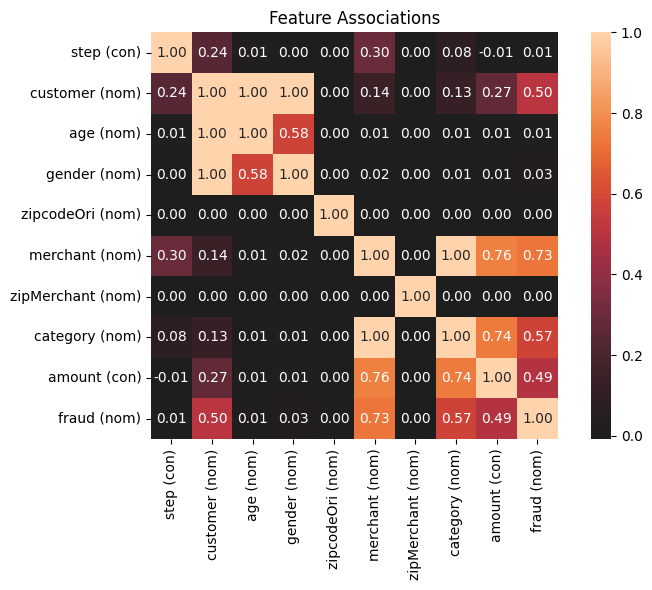

In [58]:
# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", square=True, cbar=True, center=0)
plt.title("Feature Associations")
plt.tight_layout()
plt.show()

### 7- Checking columns with high correlation with target column

#### 7.1 Amount

__Notes__:
* Fraudulent records tend to have greater amount values on average than non-fraudulent transactions.

In [59]:
non_fraudulent_df = df[df["fraud"] == 0].copy(deep=True)
fraudulent_df = df[df["fraud"] == 1].copy(deep=True)

In [60]:
non_fraudulent_df["amount"].median()

np.float64(26.61)

In [61]:
fraudulent_df["amount"].median()

np.float64(319.175)

In [62]:
non_fraudulent_df["amount"].describe(percentiles=PERCENTILES).to_frame()

,amount
count,587443.000000
mean,31.847230
std,31.470876
min,0.000000
0%,0.000000
2.5%,1.380000
5%,2.760000
7.5%,4.140000
10%,5.510000
12.5%,6.880000


In [63]:
fraudulent_df["amount"].describe(percentiles=PERCENTILES).to_frame()

,amount
count,7200.000000
mean,530.926551
std,835.587112
min,0.030000
0%,0.030000
2.5%,16.446750
5%,30.945500
7.5%,45.338500
10%,61.450000
12.5%,76.696250


#### Verifying that both distributions of "Amount" values are different via the Kolmogorov–Smirnov (K–S) Test
Assuming 5% significance level

In [64]:
stat, p = ks_2samp(
    fraudulent_df["amount"],
    non_fraudulent_df["amount"]
)

In [65]:
print("KS-statistic:", stat, "p-value:", p)

KS-statistic: 0.8318216467148491 p-value: 0.0


##### p_value < 0.05 -> statistically significant difference between the two datasets in terms of "Amount" values (null hypothesis rejected)

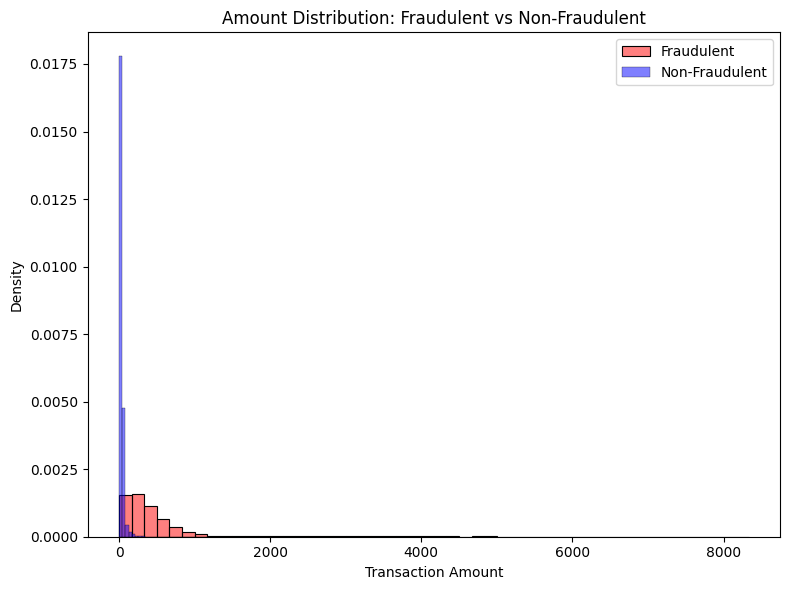

In [66]:
plt.figure(figsize=(8, 6))
sns.histplot(
    fraudulent_df['amount'],
    color='red',
    label='Fraudulent',
    stat='density', # normalize to density
    bins=50,
    kde=False,
    alpha=0.5
)
sns.histplot(
    non_fraudulent_df['amount'],
    color='blue',
    label='Non-Fraudulent',
    stat='density',
    bins=50,
    kde=False,
    alpha=0.5
)
plt.xlabel('Transaction Amount')
plt.ylabel('Density')
plt.title('Amount Distribution: Fraudulent vs Non-Fraudulent')
plt.legend()
plt.tight_layout()
plt.show()

#### 7.2 customer

__Notes__:
* 4,112 unique customers.
* 2,629 customer (63.9348%) had no "fraudulent" transactions.
* 1,483 customers (36.0651%) had at least one "fraudulent" transaction.
* 393 customers (9.56%) had >= 5% of their transactions as being fraudulent.  

In [67]:
df["customer"].nunique()

4112

In [68]:
df["customer"].value_counts().to_frame()[:20]

,count
customer,
C1978250683,265
C1275518867,252
C806399525,237
C515668508,205
C1338396147,195
C1896850232,192
C1350963410,191
C980876590,189
C582688427,188


In [69]:
fraud_per_customer = df.groupby('customer').agg(
    transactions=('fraud', 'size'),
    fraud_count=('fraud', 'sum'),
    fraud_ratio=('fraud', 'mean'),
    avg_amount=('amount', 'mean'),
    median_amount=('amount', 'median')
).sort_values('fraud_ratio', ascending=False)

In [70]:
fraud_per_customer.shape

(4112, 5)

In [71]:
fraud_per_customer.head(100)

,transactions,fraud_count,fraud_ratio,avg_amount,median_amount
customer,,,,,
C910454738,92,87,0.945652,410.820761,335.995
C2004941826,126,119,0.944444,513.897460,296.030
C381007057,100,89,0.890000,513.888700,254.180
C1572610482,101,89,0.881188,581.060693,311.040
C617723960,46,40,0.869565,517.910217,272.760
C2113737065,91,79,0.868132,432.317912,262.610
C2060410910,13,11,0.846154,561.948462,157.810
C483912131,98,80,0.816327,514.925714,278.060
C1809646275,5,4,0.800000,270.310000,258.290


In [72]:
fraud_per_customer.describe(percentiles=PERCENTILES)

,transactions,fraud_count,fraud_ratio,avg_amount,median_amount
count,4112.000000,4112.000000,4112.000000,4112.000000,4112.000000
mean,144.611625,1.750973,0.023469,45.335268,30.582788
std,42.788212,7.053622,0.081532,48.922168,20.365618
min,5.000000,0.000000,0.000000,23.372024,18.560000
0%,5.000000,0.000000,0.000000,23.372024,18.560000
2.5%,20.000000,0.000000,0.000000,27.111448,22.447750
5%,43.000000,0.000000,0.000000,27.811505,23.242750
7.5%,64.000000,0.000000,0.000000,28.323545,23.643250
10%,77.000000,0.000000,0.000000,28.680959,24.025500
12.5%,88.000000,0.000000,0.000000,28.979398,24.290000


In [73]:
fraud_per_customer[fraud_per_customer["fraud_ratio"] == 0].shape

(2629, 5)

In [74]:
fraud_per_customer[fraud_per_customer["fraud_ratio"] == 0].shape[0] / fraud_per_customer.shape[0]

0.6393482490272373

In [75]:
fraud_per_customer[fraud_per_customer["fraud_ratio"] > 0].shape

(1483, 5)

In [76]:
fraud_per_customer[fraud_per_customer["fraud_ratio"] > 0].shape[0] / fraud_per_customer.shape[0]

0.36065175097276264

In [77]:
fraud_per_customer[fraud_per_customer["fraud_ratio"] >= 0.05].shape

(393, 5)

In [78]:
fraud_per_customer[fraud_per_customer["fraud_ratio"] >= 0.05].shape[0] / fraud_per_customer.shape[0]

0.09557392996108949

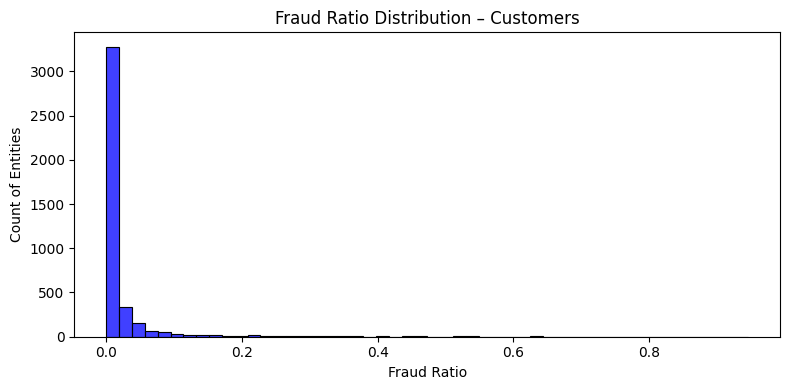

In [79]:
plt.figure(figsize=(8, 4))
sns.histplot(fraud_per_customer["fraud_ratio"], bins=50, color='blue', kde=False)
plt.title(f'Fraud Ratio Distribution – Customers')
plt.xlabel('Fraud Ratio')
plt.ylabel('Count of Entities')
plt.tight_layout()
plt.show()

#### 7.3 merchant

__Notes__:
* 50 unique merchants.
* 20 merchants (40%) had no "fraudulent" transactions.
* 30 merchants (60%) had at least one "fraudulent" transaction.
* 25 merchants (50%) had >= 5% of their transactions as being fraudulent.  

In [80]:
df["merchant"].nunique()

50

In [81]:
df["merchant"].value_counts().to_frame()[:20]

,count
merchant,
M1823072687,299693
M348934600,205426
M85975013,26254
M1053599405,6821
M151143676,6373
M855959430,6098
M1946091778,5343
M1913465890,3988
M209847108,3814


In [82]:
fraud_per_merchant = df.groupby('merchant').agg(
    transactions=('fraud', 'size'),
    fraud_count=('fraud', 'sum'),
    fraud_ratio=('fraud', 'mean'),
    avg_amount=('amount', 'mean'),
    median_amount=('amount', 'median')
).sort_values('fraud_ratio', ascending=False)

In [83]:
fraud_per_merchant.shape

(50, 5)

In [84]:
fraud_per_merchant.head(50)

,transactions,fraud_count,fraud_ratio,avg_amount,median_amount
merchant,,,,,
M1294758098,191,184,0.963351,289.667120,289.440
M3697346,308,290,0.941558,288.442597,300.355
M1873032707,250,216,0.864000,376.237320,291.740
M732195782,608,518,0.851974,2325.101398,1964.460
M980657600,1769,1472,0.832109,299.963646,249.050
M1353266412,78,64,0.820513,377.828462,308.425
M857378720,122,92,0.754098,356.235000,301.455
M2080407379,48,36,0.750000,2299.512292,2074.950
M2011752106,244,166,0.680328,323.581270,222.255


In [85]:
fraud_per_merchant.describe(percentiles=PERCENTILES)

,transactions,fraud_count,fraud_ratio,avg_amount,median_amount
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,11892.860000,144.000000,0.233471,269.751482,221.109700
std,50682.345889,311.987441,0.321460,489.889725,416.520683
min,3.000000,0.000000,0.000000,26.953146,24.960000
0%,3.000000,0.000000,0.000000,26.953146,24.960000
2.5%,27.075000,0.000000,0.000000,29.239136,26.891375
5%,57.450000,0.000000,0.000000,39.946179,34.732750
7.5%,69.000000,0.000000,0.000000,44.148716,36.594000
10%,77.100000,0.000000,0.000000,44.582211,37.875000
12.5%,108.875000,0.000000,0.000000,47.303843,40.326875


In [86]:
fraud_per_merchant[fraud_per_merchant["fraud_ratio"] == 0].shape

(20, 5)

In [87]:
fraud_per_merchant[fraud_per_merchant["fraud_ratio"] == 0].shape[0] / fraud_per_merchant.shape[0]

0.4

In [88]:
fraud_per_merchant[fraud_per_merchant["fraud_ratio"] > 0].shape

(30, 5)

In [89]:
fraud_per_merchant[fraud_per_merchant["fraud_ratio"] > 0].shape[0] / fraud_per_merchant.shape[0]

0.6

In [90]:
fraud_per_merchant[fraud_per_merchant["fraud_ratio"] >= 0.05].shape

(25, 5)

In [91]:
fraud_per_merchant[fraud_per_merchant["fraud_ratio"] >= 0.05].shape[0] / fraud_per_merchant.shape[0]

0.5

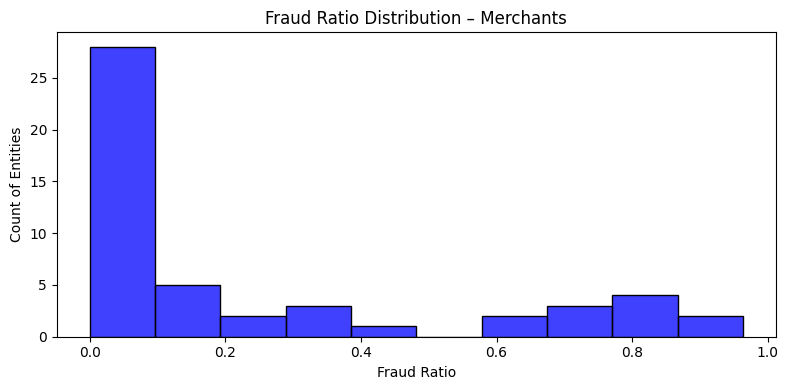

In [92]:
plt.figure(figsize=(8, 4))
sns.histplot(fraud_per_merchant["fraud_ratio"], bins=10, color='blue', kde=False)
plt.title(f'Fraud Ratio Distribution – Merchants')
plt.xlabel('Fraud Ratio')
plt.ylabel('Count of Entities')
plt.tight_layout()
plt.show()

#### 7.4 category

__Notes__:
* 15 unique categories.
* 3 categories (20%) had no "fraudulent" transactions.
* 12 categories (80%) had at least one "fraudulent" transaction.
* 8 categories (53%) had >= 5% of their transactions as being fraudulent.
    * __es_leisure__: 94.9% of transactions being fraudulent.
    * __es_travel__: 79.39% of transactions being fraudulent.
    * __es_sportsandtoys__:  49.5252% of transactions being fraudulent.
    * __es_hotelservices__:  31.422% of transactions being fraudulent.
    * __es_otherservices__:  25% of transactions being fraudulent.
    * __es_home__:  15.2% of transactions being fraudulent.
    * __es_health__:  10.51% of transactions being fraudulent.
    * __es_tech__:  6.667% of transactions being fraudulent.

In [93]:
df["category"].nunique()

15

In [94]:
df["category"].value_counts().to_frame()[:20]

,count
category,
es_transportation,505119
es_food,26254
es_health,16133
es_wellnessandbeauty,15086
es_fashion,6454
es_barsandrestaurants,6373
es_hyper,6098
es_sportsandtoys,4002
es_tech,2370


In [95]:
fraud_per_category = df.groupby('category').agg(
    transactions=('fraud', 'size'),
    fraud_count=('fraud', 'sum'),
    fraud_ratio=('fraud', 'mean'),
    avg_amount=('amount', 'mean'),
    median_amount=('amount', 'median')
).sort_values('fraud_ratio', ascending=False)

In [96]:
fraud_per_category.shape

(15, 5)

In [97]:
fraud_per_category.head(15)

,transactions,fraud_count,fraud_ratio,avg_amount,median_amount
category,,,,,
es_leisure,499,474,0.949900,288.911303,296.660
es_travel,728,578,0.793956,2250.409190,1888.460
es_sportsandtoys,4002,1982,0.495252,215.715280,134.175
es_hotelservices,1744,548,0.314220,205.614249,131.940
es_otherservices,912,228,0.250000,135.881524,87.280
es_home,1986,302,0.152064,165.670846,111.310
es_health,16133,1696,0.105126,135.621367,97.890
es_tech,2370,158,0.066667,120.947937,90.390
es_wellnessandbeauty,15086,718,0.047594,65.511221,51.895


In [98]:
fraud_per_category.describe(percentiles=PERCENTILES)

,transactions,fraud_count,fraud_ratio,avg_amount,median_amount
count,15.000000,15.000000,15.000000,15.000000,15.00000
mean,39642.866667,480.000000,0.217167,256.530477,207.70000
std,128979.359378,597.478989,0.301832,557.105201,469.95769
min,499.000000,0.000000,0.000000,26.958187,24.96000
0%,499.000000,0.000000,0.000000,26.958187,24.96000
2.5%,579.150000,0.000000,0.000000,30.497463,27.94025
5%,659.300000,0.000000,0.000000,34.036740,30.92050
7.5%,735.850000,0.000000,0.000000,37.389935,33.61475
10%,790.800000,0.000000,0.000000,39.626648,34.59300
12.5%,845.750000,0.000000,0.000000,41.863361,35.57125


In [99]:
fraud_per_category[fraud_per_category["fraud_ratio"] == 0].shape

(3, 5)

In [100]:
fraud_per_category[fraud_per_category["fraud_ratio"] == 0].shape[0] / fraud_per_category.shape[0]

0.2

In [101]:
fraud_per_category[fraud_per_category["fraud_ratio"] > 0].shape

(12, 5)

In [102]:
fraud_per_category[fraud_per_category["fraud_ratio"] > 0].shape[0] / fraud_per_category.shape[0]

0.8

In [103]:
fraud_per_category[fraud_per_category["fraud_ratio"] >= 0.05].shape

(8, 5)

In [104]:
fraud_per_category[fraud_per_category["fraud_ratio"] >= 0.05].shape[0] / fraud_per_category.shape[0]

0.5333333333333333

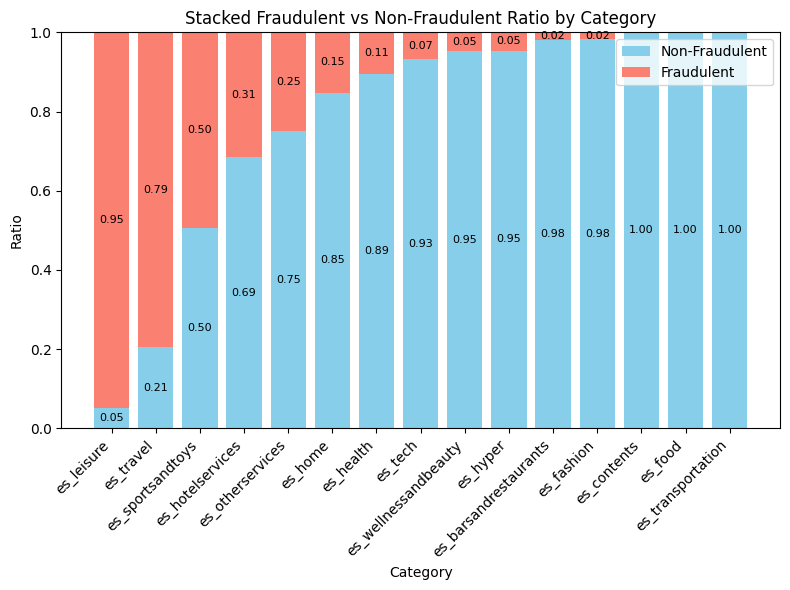

In [105]:
# 1. Compute counts per category and fraud status
ct = df.groupby(['category', 'fraud']).size().unstack(fill_value=0)

# 2. Convert counts to per-category ratios (sum = 1)
fraud_ratio_df = ct.div(ct.sum(axis=1), axis=0).reset_index()
fraud_ratio_df.columns = ['category', 'non_fraud_ratio', 'fraud_ratio']

# 3. Sort categories by descending fraud_ratio
fraud_ratio_df = fraud_ratio_df.sort_values('fraud_ratio', ascending=False)

# Prepare data for plotting
categories = fraud_ratio_df['category']
non_fraud = fraud_ratio_df['non_fraud_ratio']
fraud = fraud_ratio_df['fraud_ratio']

plt.figure(figsize=(8, 6))
# Plot non-fraud base
plt.bar(categories, non_fraud, label='Non-Fraudulent', color='skyblue')
# Stack fraud on top, ensuring total height = 1
plt.bar(categories, fraud, bottom=non_fraud, label='Fraudulent', color='salmon')

plt.title('Stacked Fraudulent vs Non-Fraudulent Ratio by Category')
plt.ylabel('Ratio')
plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')

# Annotate percentages inside the bars
for idx, (cf, ff) in enumerate(zip(non_fraud, fraud)):
    # non-fraud annotation
    if cf > 0:
        plt.text(idx, cf / 2, f'{cf:.2f}', ha='center', va='center', fontsize=8)
    # fraud annotation
    if ff > 0:
        plt.text(idx, cf + ff / 2, f'{ff:.2f}', ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

### 8- Saving data

In [106]:
df.shape

(594643, 10)

In [107]:
df.head(10)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0
5,0,C1315400589,3,F,28007,M348934600,28007,es_transportation,25.81,0
6,0,C765155274,1,F,28007,M348934600,28007,es_transportation,9.10,0
7,0,C202531238,4,F,28007,M348934600,28007,es_transportation,21.17,0
8,0,C105845174,3,M,28007,M348934600,28007,es_transportation,32.40,0
9,0,C39858251,5,F,28007,M348934600,28007,es_transportation,35.40,0


In [108]:
df.to_csv("fraud_cleaned.csv", index=False)